In [15]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
name = 'house'
data_dir = 'data'

# images
I1 = plt.imread(data_dir + '/' + name + '/house1.jpg')
I2 = plt.imread(data_dir + '/' + name + '/house2.jpg')

# K matrices
qq = loadmat(data_dir + '/' + name + '/house1_K.mat')
K1 = qq['K']
print(K1.shape)
qq = loadmat(data_dir + '/' + name + '/house2_K.mat')
K2 = qq['K']

# corresponding points
matches = [x.split('  ')[1:] for x in open(data_dir + '/' + name + '/house_matches.txt').readlines()] 
matches = [[float(y) for y in x] for x in matches]
matches = np.array(matches)

# this is a N x 4 where:
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is the corresponding point in the second image

(3, 3)


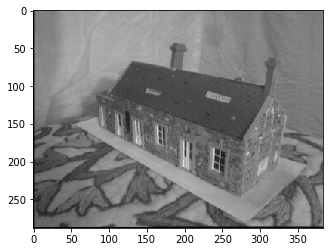

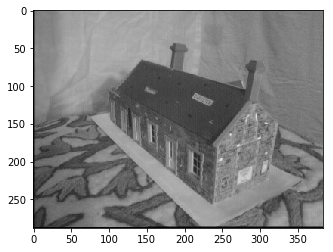

matches shape: (168, 4)


In [45]:

plt.imshow(I1)
plt.show()
plt.imshow(I2)
plt.show()
print("matches shape:", matches.shape)

In [46]:
'''The function that returns the fundamental matrix described in 1.4.1 (Eight Point Algorithm).
This function takes in atleast 8 corresponding points and returns the matrix F and the residual.
'''
def fundamental_matrix(matches):
    #TODO (do this with normalization)

    # normalize
    
    # write mean + std transformations as matrices
    set1 = matches[:, 0:2]
    set2 = matches[:, 2:4]
    
    """mean_fn1, std_fn1 = get_normalize_fns(set1)
    mean_fn2, std_fn2 = get_normalize_fns(set2)"""
    T_1 = get_normalize_mat(set1)
    T_2 = get_normalize_mat(set2)
    set1 = normalize(set1, T_1)
    set2 = normalize(set2, T_2)
    #print(set1)
    A = np.stack(
        [set1[:, 0] * set2[:, 0],
         set1[:, 1] * set2[:, 0],
         set2[:, 0],
         set1[:, 0] * set2[:, 1],
         set1[:, 1] * set2[:, 1],
         set2[:, 1],
         set1[:, 0],
         set1[:, 1],
         np.ones(set1[:, 0].shape)], axis=1)
    U, s, Vh = np.linalg.svd(A)
    F_star = Vh[-1].reshape(3, 3).T
    U, s, Vh = np.linalg.svd(F_star)
    s[2] = 0
    return T_2.T @ U @ np.diag(s) @ Vh @ T_1

##Josh Added
'''
This function gets the normalization matrix that can be applied to a data point in HOMOGENOUS
coordinates
'''
def get_normalize_mat(s):
    mu = np.mean(s, axis=0)
    sigma = np.std(np.linalg.norm(s, axis=1))
    return 1/sigma * np.array([[1, 0 ,-mu[0]],
                               [0, 1, -mu[1]],
                               [0, 0,  sigma]])
####

# def normalize(s):
#     return (s - np.mean(s, axis=1).reshape(s.shape[0], 1)) / \
#             np.std(s, axis=1).reshape(s.shape[0], 1)
'''
This normalization method converts to homogenous coordinates to use the tranformation T.
I think this is the correct way
'''
def normalize(s, T):
    ones = np.ones(s.T[0].shape)
    s_prime = np.stack([s.T[0], s.T[1], ones], axis=0)
    return (T @ s_prime).T[:,:2]

def get_normalize_fns(s):
    mean = np.mean(s, axis=0)
    std = np.std(s, axis=0)
    s_homogenous = np.stack([s, np.ones(s.shape[0], 1)], axis=1).T
    
    mean_transformation = np.eye(3)
    mean_transformation[1]
    std_transformation = np.diag(1 / std)

'''Given E, calculates and returns both the rotation and translation between the two cameras.
Described in part 1.4.2. Returning the magnitude of t is impossible, so we return
an array of possible t's and an array of possible R's.
'''
def find_rotation_translation(E):
    U, Sigma, Vh = np.linalg.svd(E)
    S = U
    print(Sigma)
    #the two singular values should be the SAME
    R90_St_R = Vh
    R90t = np.array([[0, 1, 0],
                     [-1, 0, 0],
                     [0, 0, 1]])
    R = R90t.T @ S @ R90_St_R
    
    t = S[:, 2]
    
    return [t, -t], [R, -R]

'''Triangulation function. This takes in the matches, P1, P2, and
finds the best 3D points that reproject to the images in the
two cameras.

This returns a Nx3 matrix of points in 3D space and the 
reconstruction scene. N depends on the number of points
that end up in front of the images planes.'''
def find_3d_points(matches, P1, P2):
    #TODO
    pass

In [51]:
#TODO: visualize matches (maybe)

F = fundamental_matrix(matches)
#print('Residual in f = ', res_err)


#calculate the ESSENTIAL matrix from the FUNDAMENTAL matrix
E = K2.T @ F @ K1

# R : cell array with the possible rotation matrices of second camera
# t : cell array of the possible translation vectors of second camera
R, t = find_rotation_translation(E) 

#P1: P matrix for camera 1
#P2 is calculated on the fly since there are multiple possibilities
print(np.identity(3).shape)
P1 = K1 @ np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0]])

# % the number of points in front of the image planes for all combinations
num_points = np.zeros((len(t), len(R)))
# % the reconstruction error for all combinations
errs = np.full((len(t), len(R)), np.inf)


for ti in range(len(t)):
    t2 = t[ti]
    for ri in range(len(R)):
        R2 = R[ri]
        P2 = K2 @ np.append(R2, t2.reshape(t2.shape[0], 1), axis=1)
        points_3d,  errs[ti, ri] = find_3d_points(matches) #TODO might need more params
        Z1 = points_3d[:, 3] #not sure if this should be 2 -sherman
        Z2 = R2[3, :]@points_3d.T + t2[3]
        Z2 = Z2.T
        num_points[ti, ri] = points_3d.shape[0]

[  4.19552463e-02   3.85611923e-02   5.85611293e-20]
(3, 3)


ValueError: cannot reshape array of size 9 into shape (3,1)